# AWS Neuron Benchmarking on Yolov8

This notebook shows how to compile Yolov8/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK.

Reference: 
- Model Prediction with Ultralytics YOLO
    - https://docs.ultralytics.com/modes/predict/

In [10]:
%load_ext autoreload
%autoreload 2

import sys, os
print(os.getcwd())
sys.path.append(os.path.abspath(".."))

# for i in sys.path:
#     print(i)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ubuntu/lab/03-yolo8-inf1/notebook


## 1. Neuron Compilation using  Native Neuron SDK

### Load yolo8 model using ultralytics Lib

In [11]:
from ultralytics import YOLO

model = YOLO("../model/yolov8n.pt", task="detect")


### Compile pytorch model to neuron model
- When having an error, skip this cell

In [12]:
from utils.local_util import * 

In [13]:
import torch
import torch_neuron
import os

pt_model_path = '../model/yolov8n.pt'
neuron_model_path = "../model/traced_yolo8_model_neuron.pt"

# generate dummy input example
batch_sizes = 1
input_shape = (batch_sizes, 3, 640, 640)
inputs_example = torch.ones(input_shape)  # or numpy array for TF, MX
print("input example shape: ", inputs_example.shape)


if os.path.exists(neuron_model_path):
    # Load the existing model
    neuron_model = load_neuron_model(neuron_model_path)
    print(f"Loaded existing model from {neuron_model_path}")
else:
    # trace the model forward
    neuron_model = torch_neuron.trace(model.model.eval(), inputs_example)
    print(f"Compile and Load model from pytorch model, {pt_model_path}, and neuron model, {neuron_model_path}")
    print(f"Neuron model is saved at, {neuron_model_path}")
    save_neuron_model(model=trace, path=neuron_model_path)

input example shape:  torch.Size([1, 3, 640, 640])
/home/ubuntu/lab/03-yolo8-inf1/model/traced_yolo8_model_neuron.pt is given


Loaded existing model from ../model/traced_yolo8_model_neuron.pt


### Inference on neuron model

##### infereince on dummy data

In [14]:
result_neuron = neuron_model(inputs_example)
print("result_neuron: ", len(result_neuron), ", shape: ", result_neuron[0].shape)

result_neuron:  2 , shape:  torch.Size([1, 84, 8400])


/home/ubuntu/miniconda3/envs/yolo8-conda-py310/lib/python3.10/site-packages/torch_neuron/data_parallel.py:220: UserWarning: The NeuronCores are not being fully utilized because `inputs.shape[dim]` is not divisible by the number of NeuronCores given in `device_ids`. In order to get optimal performance, please try to ensure that the shape your inputs at `dim` is divisible by the number of NeuronCores that DataParallel is using, such that `input.shape[dim] % len(device_ids) == 0).`
  warnings.warn('The NeuronCores are not being fully utilized because '


##### infereince on bus image and post_processing

In [15]:
import cv2
import numpy as np
from ultralytics import YOLO

# convert image to numpy array which shapes, [1,3,640,640]
image_path = "../test_image/bus.jpg"
preprocessed_image, original_size = preprocess_image(image_path)

print("preprocessed_image: ", preprocessed_image.shape)
print("original_size: ", original_size)

preprocessed_image_torch = torch.from_numpy(preprocessed_image)

preprocessed_image:  (1, 3, 640, 640)
original_size:  (1080, 810)


### Benchmarking

Benchmark Results:
Average Inference Time: 28.91 ms
Standard Deviation: 0.21 ms
Min Inference Time: 28.52 ms
Max Inference Time: 31.76 ms


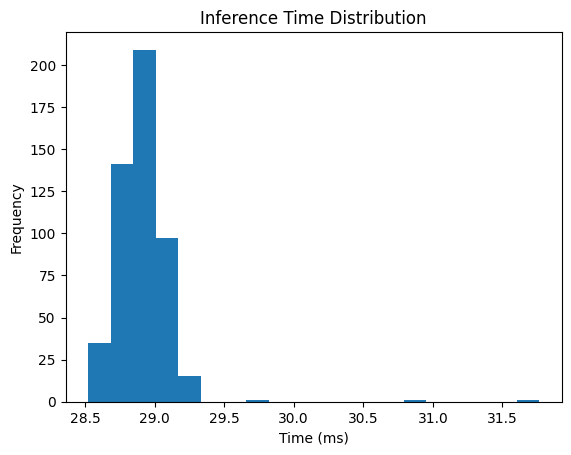

In [22]:
# 이미지 경로
# image_path = "../test_image/bus.jpg"

# 벤치마킹 실행
results = benchmark_inference_neuron(neuron_model, preprocessed_image_torch, 
                              num_runs=500, num_warmup=10)

# 결과 출력
show_benchmark_results(results)    

## 2. Compile and inference using ultralytics lib

### Load pytorch model, yolo8, and compile it to neuron model

In [17]:
from ultralytics import YOLO

import os

pt_model_path = '../model/yolov8n.pt'
neuron_model_path = '../model/yolov8n.neuron'

if os.path.exists(neuron_model_path):
    # Load the existing model
    # m_inf= YOLO("../model/traced_yolo8_model_neuron.pt", task="detect")
    m_inf= YOLO(neuron_model_path, task="detect")
    print(f"Loaded existing model from {neuron_model_path}")
else:
    mx=YOLO(pt_model_path)
    mx.export(format="neuron")
    # m_inf= YOLO("model/yolov8n.neuron", task="detect")
    m_inf= YOLO(neuron_model_path, task="detect")
    print(f"Compile and Load model from pytorch model, {pt_model_path}, and neuron model, {neuron_model_path}")



Loaded existing model from ../model/yolov8n.neuron



image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 26.1ms
Speed: 2.1ms preprocess, 26.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.8ms
Speed: 1.9ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.7ms
Speed: 2.0ms preprocess, 25.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at sha

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/ubuntu/lab/03-yolo8-inf1/notebook/../test_image/bus.jpg: 640x640 4 persons, 1 bus, 25.7ms
Speed: 2.0ms preprocess, 25.7ms inference, 0.8ms postprocess per image at shap

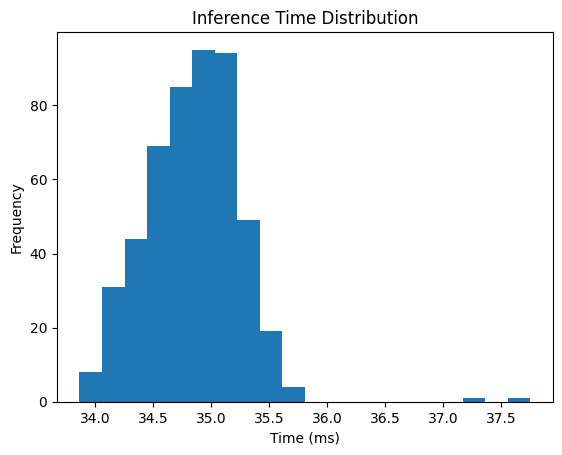

In [23]:
# 이미지 경로
image_path = "../test_image/bus.jpg"

# 벤치마킹 실행
results = benchmark_inference_ultralytics(m_inf, image_path, 
                              num_runs=500, num_warmup=10)

# 결과 출력
show_benchmark_results(results)    